<a href="https://colab.research.google.com/github/KirtiNayak11/SkinCancerDetection_EnsembleLearning/blob/main/SkinCancerDetection_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Setting Up Kaggle API Credentials**

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

**Downloading the Multi-Cancer dataset**

In [ ]:
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign

 99% 321M/325M [00:04<00:00, 39.9MB/s]
100% 325M/325M [00:04<00:00, 70.4MB/s]


**Extracting Multi-Cancer Dataset**

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/skin-cancer-malignant-vs-benign.zip', 'r')
zip_ref.extractall('/content/drive/MyDrive/skinCancerDetection')
zip_ref.close()

**Class Distribution Analysis for MultiCancer Dataset**

In [ ]:
import tensorflow as tf

In [ ]:
data_dir = '/content/drive/MyDrive/skinCancerDetection/train'

In [ ]:
import os
class_counts = {}
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images

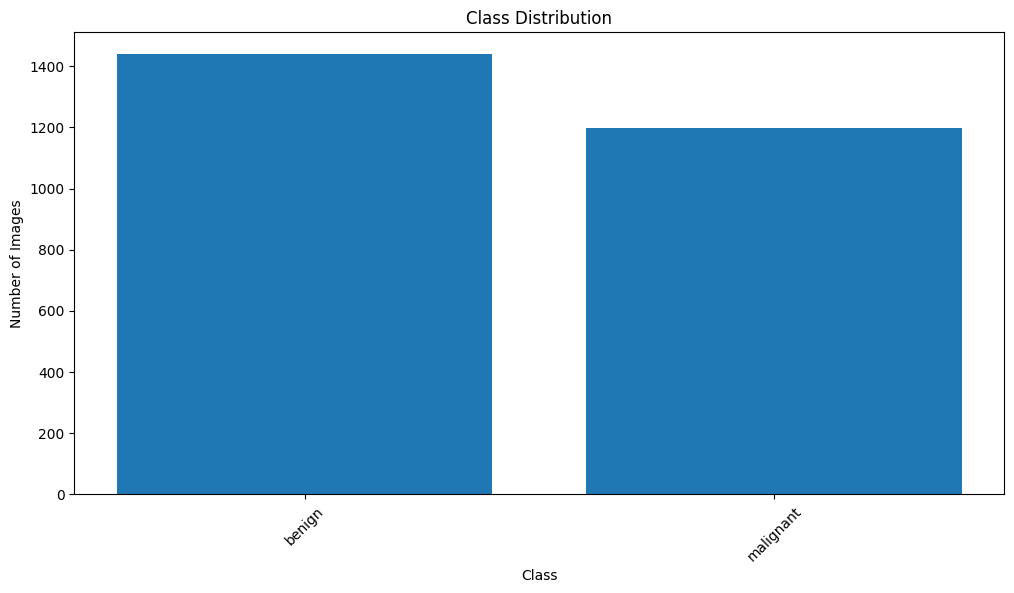

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

**Loading and Preprocessing Image**

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/skinCancerDetection/train',
    image_size=(224, 224),
    batch_size=32,
    seed=123,
    shuffle=True,
    label_mode="categorical"
)

Found 2637 files belonging to 2 classes.


In [ ]:
class_names = dataset.class_names
class_names

['benign', 'malignant']

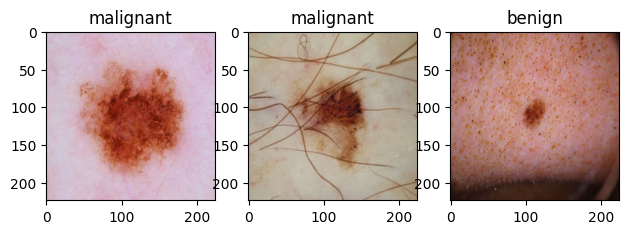

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(3):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        label_index = tf.where(labels_batch[i] == 1).numpy()[0][0]
        plt.title(class_names[label_index])

plt.show()

**Splitting Dataset into Train, Validation, and Test Sets**

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8,val_split=0.2, shuffle=False, shuffle_size=500):
    assert (train_split + val_split ) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size)

    return train_ds,val_ds

In [ ]:
train_ds,val_ds = get_dataset_partitions_tf(dataset)

In [ ]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255.0)

In [ ]:
train_ds = train_ds.map(lambda x, y: (rescale(x), y))

In [ ]:
val_ds = val_ds.map(lambda x, y: (rescale(x), y))

In [ ]:
len(train_ds)

66

In [ ]:
len(val_ds)

17

**Building Skin Cancer Classification Model**

In [ ]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K

from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers, models
import cv2
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras import layers, models

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(128,(3,3), input_shape = (224,224,3) ,activation = tf.nn.relu ))
model.add(tf.keras.layers.MaxPool2D(pool_size=(3,3),strides=None))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64,activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(32,activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(2,activation=tf.nn.softmax))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 128)       0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 700928)            0         
                                                                 
 dense (Dense)               (None, 64)                44859456  
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                        

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

learning_rate = 0.001

optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_ds,
    epochs=50,
    batch_size=32,
    validation_data=val_ds,
    callbacks=[early_stopping]
)


Epoch 1/50
66/66 [==============================] - 285s 4s/step - loss: 1.6995 - accuracy: 0.6278 - val_loss: 0.4877 - val_accuracy: 0.7543
Epoch 2/50
66/66 [==============================] - 286s 4s/step - loss: 0.5161 - accuracy: 0.7415 - val_loss: 0.4544 - val_accuracy: 0.7619
Epoch 3/50
66/66 [==============================] - 280s 4s/step - loss: 0.4922 - accuracy: 0.7481 - val_loss: 0.4244 - val_accuracy: 0.7924
Epoch 4/50
66/66 [==============================] - 283s 4s/step - loss: 0.4552 - accuracy: 0.7794 - val_loss: 0.4195 - val_accuracy: 0.7943
Epoch 5/50
66/66 [==============================] - 270s 4s/step - loss: 0.4279 - accuracy: 0.7978 - val_loss: 0.3579 - val_accuracy: 0.8152
Epoch 6/50
66/66 [==============================] - 282s 4s/step - loss: 0.4142 - accuracy: 0.7936 - val_loss: 0.3881 - val_accuracy: 0.8038
Epoch 7/50
66/66 [==============================] - 283s 4s/step - loss: 0.3843 - accuracy: 0.8082 - val_loss: 0.3908 - val_accuracy: 0.8057
Epoch 8/50
66

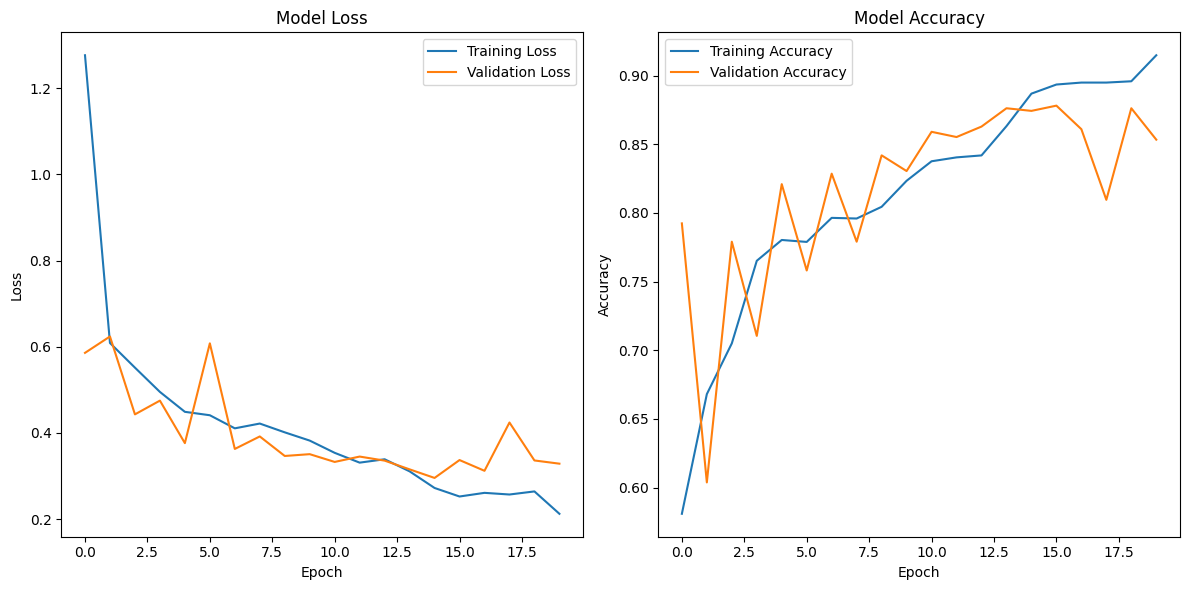

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


**Evaluating Model Performance on Test Data**

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/skinCancerDetection/test',
    image_size=(224, 224),
    batch_size=32,
    seed=123,
    shuffle=True,
    label_mode="categorical"
)

Found 660 files belonging to 2 classes.


In [ ]:
test_ds = test_ds.map(lambda x, y: (rescale(x), y))

In [ ]:
test_results = model.evaluate(test_ds)

print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

21/21 [==============================] - 22s 926ms/step - loss: 0.3671 - accuracy: 0.8364
Test Loss: 0.3671319782733917
Test Accuracy: 0.8363636136054993


**Testing Model Performance on a Sample from Test Dataset**

In [ ]:
import numpy as np

1/1 [==============================] - 0s 179ms/step
actual label: benign
predicted label: malignant


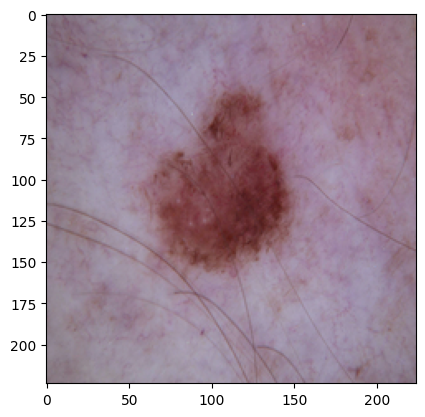

In [ ]:
for images, labels in test_ds.take(1):
        for i in range(1):
            image = images[i]
            actual_label = tf.argmax(labels[i]).numpy()

            plt.imshow(image)

            predictedValue = model.predict(np.expand_dims(image, axis=0))
            predicted_label = np.argmax(predictedValue)

            print("actual label:", class_names[actual_label])
            print("predicted label:", class_names[predicted_label])


**Analyzing Model Performance: Confusion Matrix and Classification Report**

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

true_labels = []

predicted_labels = []

for image_batch, labels_batch in test_ds:
    n= image_batch.shape[0]

    for i in range(n):
      batch_prediction = model.predict(np.expand_dims(image_batch[i], axis=0))
      predicted_indices_batch = np.argmax(batch_prediction)
      predicted_labels.append(predicted_indices_batch)

      label_index = tf.where(labels_batch[i] == 1).numpy()[0][0]
      true_labels.append(label_index)

1/1 [==============================] - 0s 70ms/step


In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[281  79]
 [ 29 271]]


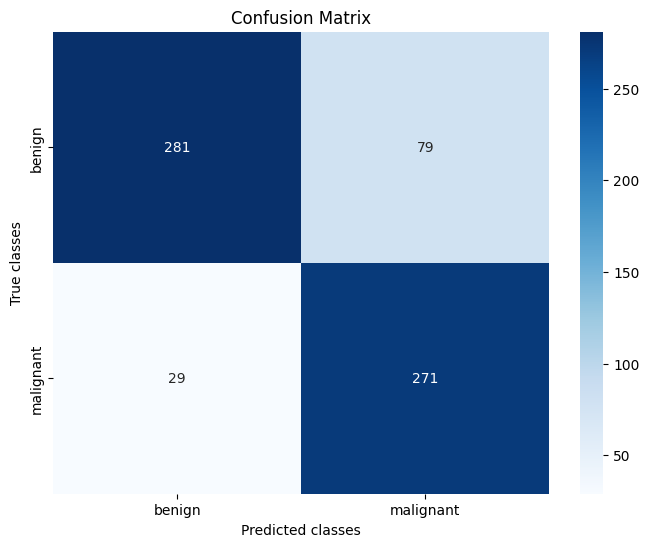

In [ ]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted classes')
plt.ylabel('True classes')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming y_true is the true labels and y_pred is the predicted labels for a multiclass problem
accuracy = accuracy_score(true_labels, predicted_labels)

# Specify the 'average' parameter for precision, recall, and f1_score
precision = precision_score(true_labels, predicted_labels, average='weighted')  # You can use 'micro', 'macro', or 'weighted'
recall = recall_score(true_labels, predicted_labels, average='weighted')  # You can use 'micro', 'macro', or 'weighted'
f1 = f1_score(true_labels, predicted_labels, average='weighted')  # You can use 'micro', 'macro', or 'weighted'
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.8363636363636363
Precision: 0.8463762044407206
Recall: 0.8363636363636363
F1-Score: 0.8365515081932992
Confusion Matrix:
[[281  79]
 [ 29 271]]


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Assuming 'model' is your trained model
# Save the entire model including architecture, optimizer, and learned weights
model.save("/content/drive/MyDrive/F1/CNN_model.h5")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#/content/drive/MyDrive/F1/CNN_model.h5